# Exercise 13: K-means Clustering

In this exercise, we will work on K-means clustering. You will be asked to cluster the MNIST dataset using the K-means algorithm. 

Let's get started!

In [1]:
import random
from base64 import b64decode
from json import loads
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Helper functions 

#### Simply run the cell below for functions related to data loading and visualization purposes

In [2]:
def parse(x):
    """
    parse the digits file into tuples of (label, vector).
    """
    
    digit = loads(x)
    array = np.frombuffer(b64decode(digit["data"]),dtype=np.ubyte)
    array = array.astype(np.float64)
    
    return (digit["label"], array)


def display_digit(digit, training_or_inferred = "training", ax=None):
    """ 
    graphically display a 784x1 vector, representing a digit, and show the corresponding label
    """
 
    image = digit[1]
    
    
    if ax is None:
        plt.figure()
        fig = plt.imshow(image.reshape(28,28))
    else:
        fig = ax.imshow(image.reshape(28,28))

    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if training_or_inferred == "training":
        title_str = "GT label: "
    else:
        title_str = "Inferred label: "
    
    if ax is None:
        plt.title(title_str  + str(digit[0]))
    else:
        ax.set_title(title_str  + str(digit[0]))

    
def display_vector(vector, ax=None):
    """ 
    graphically display a 784x1 vector, representing a digit, without showing the label
    
    """
    
    if ax is None:
        plt.figure()
        fig = plt.imshow(vector.reshape(28,28))
    else:
        fig = ax.imshow(vector.reshape(28,28))

    
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
       

## 1. Load and visualize the dataset

First of all, unzip the file **'mnist.json.zip'**; you will get the data file 'mnist.json', which contains gray-scale images of handwritten digits, from 0 to 9.

Each image is a vector of size 784 containing integers in the range [0,255]. Each image can be reshaped to $28\times 28$. Each value in the vector indicates the brightness of a pixel. That is, the higher number the brighter the pixel.

Now we will load data samples from the .json file, and split them into training, validation, and test datasets. We choose the first 10000 data points as training dataset, then 5000 data points for validation, and 5000 data points as test dataset.

#### Load the dataset and split it into three sets

In [3]:
# load the data
with open("mnist.json","r") as f:
    digits = list(map(parse, f.readlines()))

# preprocess the data from [0,255] to [0,1]  
for i, data in enumerate(digits):
    digits[i] = list(digits[i])
    digits[i][1] = data[1].astype(np.float32) / 255.
    digits[i] = tuple(digits[i])
    
# full dataset contains 60K samples
print("No of samples in full dataset   : {}\n".format(len(digits)))

# we conduct our experiments on a subset of data due to limited hardware resources
num_train, num_val, num_test = 10000, 5000, 5000

# split the dataset into training, validation and test datasets
train_data = digits[:num_train]
val_data = digits[num_train:num_train+num_val]
test_data = digits[num_train+num_val:num_train+num_val+num_test]


print("Nb of samples in the training set   : {}".format(len(train_data)))
print("Nb of samples in the validation set : {}".format(len(val_data)))
print("Nb of samples in the test set       : {}".format(len(test_data)))

No of samples in full dataset   : 60000

Nb of samples in the training set   : 10000
Nb of samples in the validation set : 5000
Nb of samples in the test set       : 5000



Let's study the structure of our newly-split datasets. 

* Each dataset is a list, in which each element is a **tuple**. 
* Each tuple contains the image's label and the image's pixel values. It is a pair of **(label, vector)**, where "label" is a single integer digit and "vector" is a vector of shape (784,).

Below, we study the training dataset and what its elements look like. 

In [4]:
print ('The type of the training dataset is    : ', type(train_data))
print ('The number of training samples is      : ', len(train_data))
print ('The type of each data sample is        : ', type(train_data[0]))
print ('The label of the first sample  is      : ', train_data[0][0])
print ('The shape of the first sample  is      : ', train_data[0][1].shape)

The type of the training dataset is    :  <class 'list'>
The number of training samples is      :  10000
The type of each data sample is        :  <class 'tuple'>
The label of the first sample  is      :  5
The shape of the first sample  is      :  (784,)


### Image visualization

We can use the helper function ```display_digit``` to display the image of each data sample.

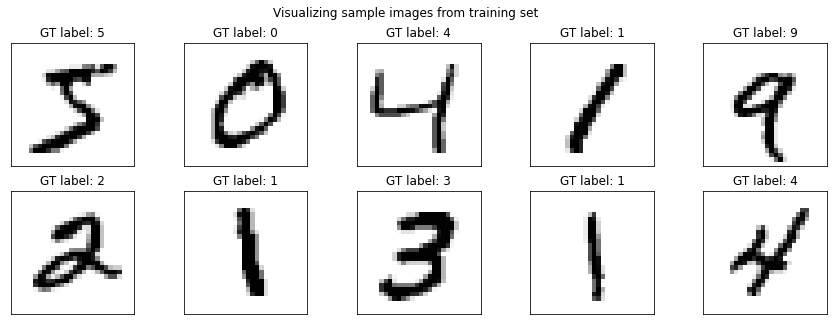

In [5]:
# For each data tuple (train_data[i]), the first element is the label (integer), 
# the second one is an vector of size (784,) containing pixel brightness values.

fig, axes = plt.subplots(2, 5, figsize=(15,5))
fig.suptitle("Visualizing sample images from training set")


for i, ax in enumerate(axes.flat):
    display_digit(train_data[i], "training", ax)


## 2. K-means clustering

Let's now group the data points into K clusters with the K-means clustering algorithm without using any labels. First, we define some basic functions which will be used later. 



**2.1**  First you will fill in the function to initialize the K cluster centers **randomly**. Pick K images randomly (i.e., only the second element in random data tuples) from the given dataset as initial cluster centers.

####  Initialize K cluster centers randomly from the given dataset


In [6]:
def initialize_cluster_centers(data, K):
    """
    "Randomly" pick K images only (without any label) from the data as the starting values for the cluster centers.
    
    input: 
        data : List of data tuples. Each element in the list is a tuple containing
              an integer label and an image vector of size (784,)
        K    : Number of clusters
    output: 
        init_centers: List containing K elements representing the initial cluster centers. Each element 
                        (i.e., cluster center) in the list is an vector of size (784,).
    """

    init_centers = []
    
    ##  YOUR CODE HERE
    sampled_centers = random.sample(data, K)
    for center in sampled_centers:
        init_centers.append(center[1])

    return init_centers

#### Let's use this ```initialize_cluster_centers``` function to first initialize 10 cluster centers and then visualize them.

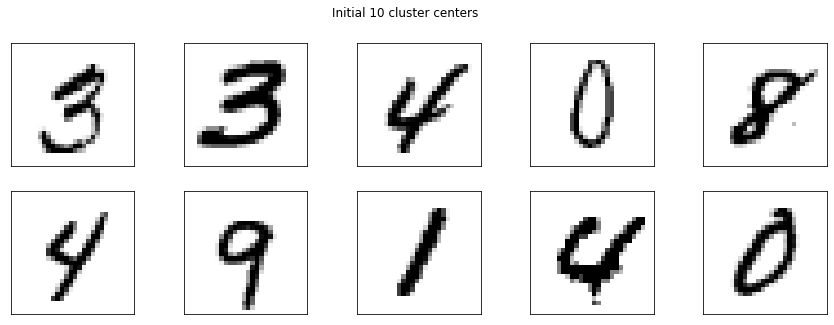

In [7]:
# Test code for init_cluster_centers: Define the number of clusters (for example, 10)
# and display the initial cluster centers


# Set number of clusters in kmeans to 10
K = 10

initial_centers = initialize_cluster_centers(train_data, K)

fig, axes = plt.subplots(2, 5, figsize=(15,5))
fig.suptitle("Initial {} cluster centers".format(K))

for i, ax in enumerate(axes.flat):
    display_vector(initial_centers[i], ax)

**2.2** You will now implement the function to form the clusters, `build_clusters`. This function assigns each data point in the dataset to one of the clusters. The data point is assigned to the **nearest** cluster center based on the L2 (Euclidean) distance.

Fill in the blank parts of the code below.

#### Assign each data point in the input dataset to the nearest cluster center based on the L2 distance

In [8]:
def build_clusters(data, centers, K):
    """
    Build the clusters by assigning each data point to the nearest center. 
    
    Note that we do not need the label information of the data points when assigning them to the nearest cluster. 
    Therefore, the K-means algorithm is an unsupervised learning method
    
    input: 
        data    : list of tuples; each tuple contains (integer label, vector of size (784,) representing an image)
        centers : list of current cluster centers; each element in the list is a vector of size (784,)
        K       : number of clusters
        
    output: 
        all_clusters: (type) List of lists of K elements. More precisely, an element at index i in the output 
                        contains a list of the data tuples assigned to the ith cluster.
    
    """

    
    #  list of lists data structure to store the clusters assignments
    all_clusters = [[] for _ in range(K)]

    
    # for each data point, pick the closest center
    for (label, image) in data:
        
        smallest_distance = float("inf")
        
        for index, center in enumerate(centers):
            
            ##  YOUR CODE HERE
            distance = np.sqrt(((image - center)**2).sum())
            
            ##  YOUR CODE HERE
            if distance < smallest_distance:
                smallest_distance = distance
                nearest_index =  index
        
        # allocate that data point to the nearest cluster center
        all_clusters[nearest_index].append((label, image))

    return all_clusters

Let's check the results after building the clusters using the training dataset and the initial cluster centers.

In [9]:
clusters = build_clusters(train_data, initial_centers, K)

for i, cluster in enumerate(clusters):    
    print ('The number of data tuples assigned to cluster {:2d} is {}'.format(i+1,len(cluster)))

The number of data tuples assigned to cluster  1 is 466
The number of data tuples assigned to cluster  2 is 560
The number of data tuples assigned to cluster  3 is 218
The number of data tuples assigned to cluster  4 is 1968
The number of data tuples assigned to cluster  5 is 603
The number of data tuples assigned to cluster  6 is 1101
The number of data tuples assigned to cluster  7 is 1921
The number of data tuples assigned to cluster  8 is 1849
The number of data tuples assigned to cluster  9 is 410
The number of data tuples assigned to cluster 10 is 904


#### Below, we take a look at the different clusters.

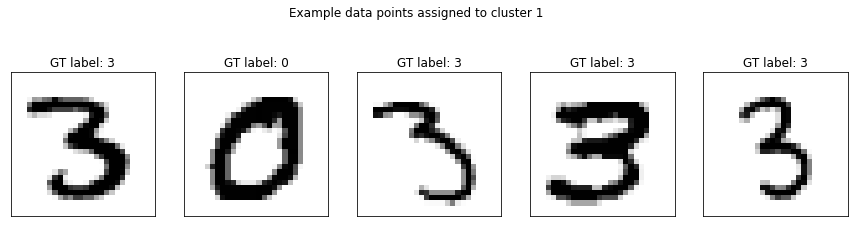

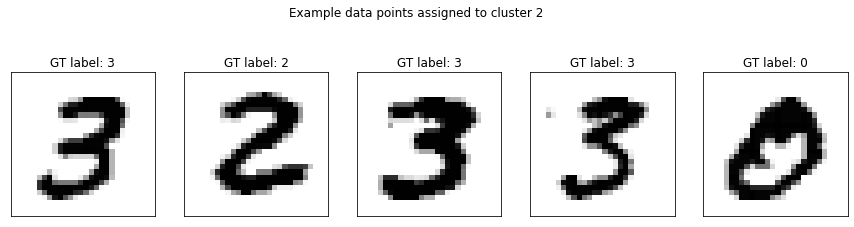

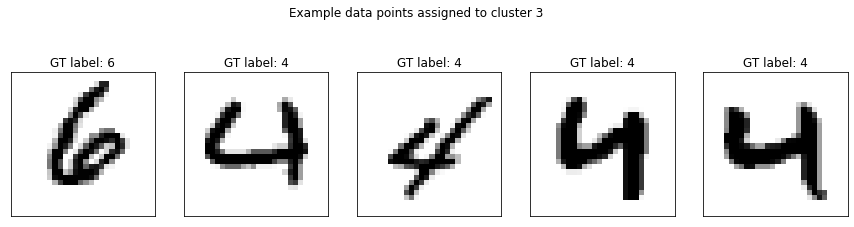

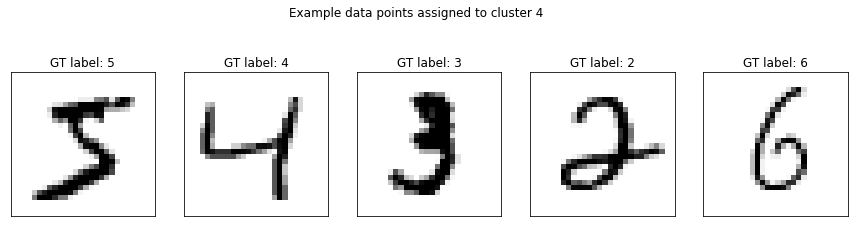

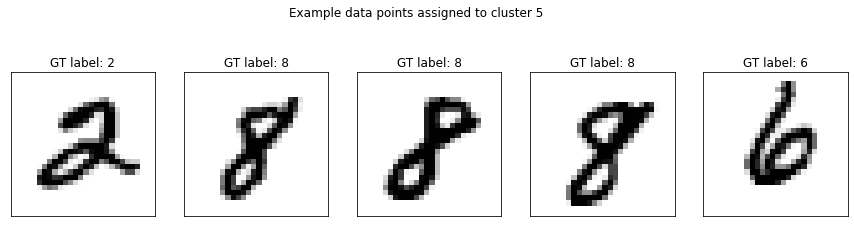

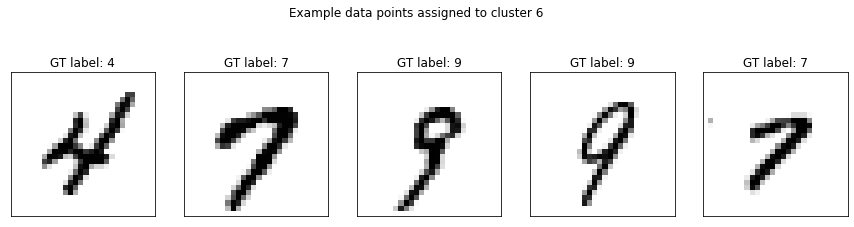

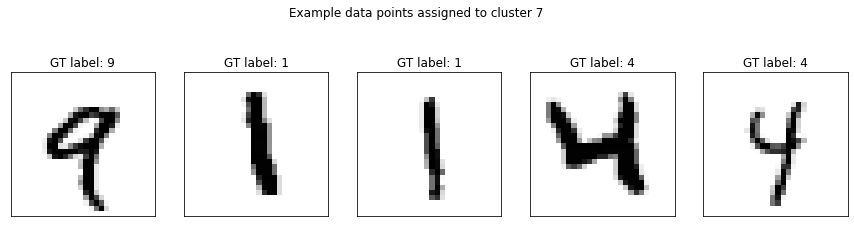

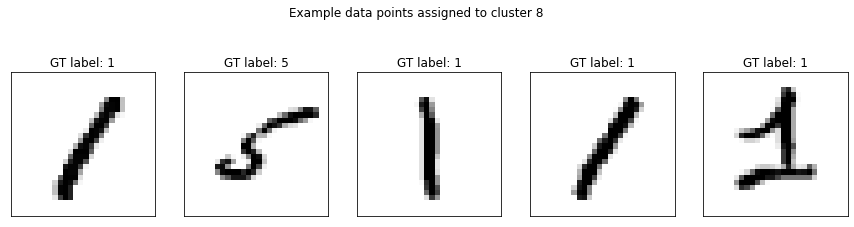

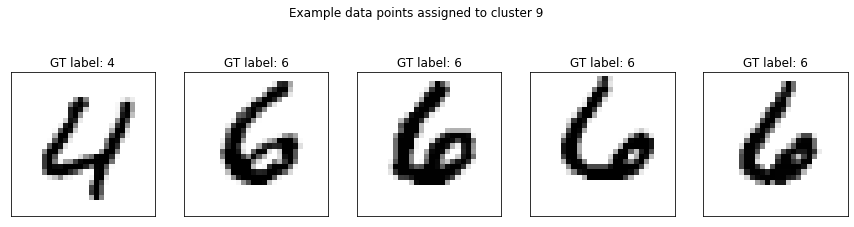

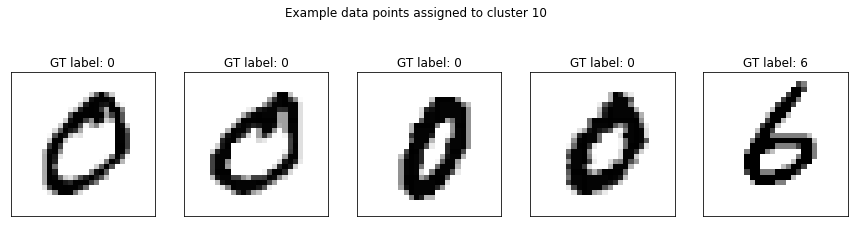

In [10]:
# test code for visualizing 5 images in each cluster

for k in range(K):
    fig, axes = plt.subplots(1, 5, figsize=(15,4))
    index = 0
    fig.suptitle("Example data points assigned to cluster {}".format(k+1))
    for col in range(5):
        display_digit(clusters[k][col], "training", axes[col])



#### 2.3 You can now fill in the function `mean_cluster()`, which updates the center of a single cluster by computing the mean of the points assigned to it.

In [11]:
# compute the center of a cluster
def compute_mean_of_cluster(single_cluster):
    """
    Compute the mean (i.e. the center) of the given cluster .
    
    input: 
        single_cluster: list of data tuples (label, image)
    output: 
        mean_of_points: the mean of the given cluster; array of shape (784,)
    """
    
    #  The initial value is the first image vector
    sum_of_points = single_cluster[0][1].copy()
    
    ## >>> YOUR CODE HERE
    for (label, image) in single_cluster[1:]: 
        sum_of_points += image
    
    # mean w.r.t. the size of the cluster
    ##  YOUR CODE HERE
    mean_of_points = sum_of_points * (1.0 / len(single_cluster))
    
    return mean_of_points

#### 2.4  Let's fill in the function `update_centers()`, which uses `compute_mean_of_cluster()` to compute the cluster centers of all the clusters.

In [12]:
# update centers
def update_centers(all_clusters):
    """
    return a list of cluster centers corresponding to the current clusters by computing their means.
    input: 
        all_clusters: list of lists; each element is a list of all data tuples associated
                        with that cluster
                        
    output: 
        new_centers: list of new cluster centers; each element is an vector of size (784,)
    """
    new_centers = []
    
    # compute the mean of each cluster
    
    ## >>> YOUR CODE HERE
    for cluster in all_clusters:
        new_centers.append(compute_mean_of_cluster(cluster))
    
    return new_centers

What do the new centers look like?

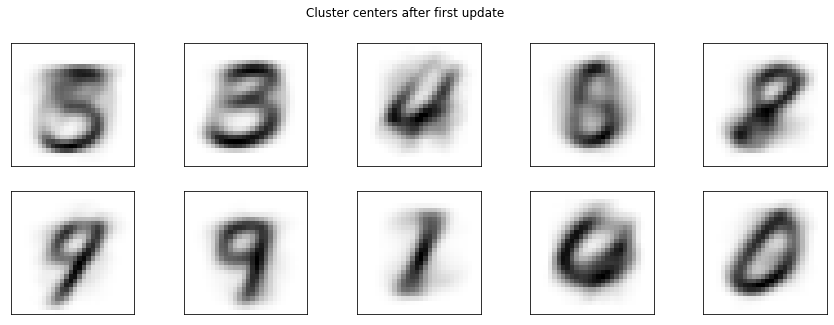

In [13]:
# test code for the first update of the centers
new_centers = update_centers(clusters)
fig, axes = plt.subplots(2, 5, figsize=(15,5))
fig.suptitle("Cluster centers after first update")


for i, ax in enumerate(axes.flat):
    display_vector(new_centers[i], ax)

K-means iterates between computing the cluster centers and building new clusters until convergence. Fill in the function ```repeat_until_convergence``` below to perform this iterative process.  

In [14]:
def repeat_until_convergence(data, centers, all_clusters, K, max_iterations=1000):
    """
    build clusters around centers, then iteratively update cluster assignments and the centers
    until the changes in cluster centers are no longer significant, i.e., we've found
    the best-fitting centers for the data and given the initial centers or we've reached the maximum number of
    iterations.
    
    input: data         : list of data tuples.
           centers      : list of initial cluster centers. 
           all_clusters : initial clusters based on inital centers
    output: 
           all_clusters: list of lists; each element is a list of data tuples obtained
                           after the last update
           centers: list of vectors; each vector of size (784,) is a final cluster center 
                           after the last update
    """
    
    iteration = 0
    previous_max_difference = 0
    while True and iteration < max_iterations:
        
        old_centers = centers.copy()
        centers = update_centers(all_clusters)
        
        ## WRITE CODE HERE
        all_clusters = build_clusters(data, centers, K)
        
        # We keep old_clusters and clusters so we can get the maximum difference
        # between the center positions at every iteration. We say that the centers have converged
        # when the maximum difference between the center positions is small or when we
        # reach the max number of iterations.   
        differences=[]
        for old_center, new_center in zip(old_centers, centers):
            difference = np.sqrt(((old_center - new_center)**2).sum())
            differences.append(difference)
            
        max_difference = max(differences)
        difference_change = abs((max_difference-previous_max_difference)/np.mean([previous_max_difference,max_difference])) * 100
        previous_max_difference = max_difference
        
        # difference change is nan once the list of differences is all zeroes.
        if np.isnan(difference_change):
            break
            
        iteration +=1
        print("Iteration {:3d}/{:3d} completed".format(iteration, max_iterations))
    
    print("Terminating the K-means algorithm at iteration {}".format(iteration))
    
    return all_clusters, centers

#### Now, let's build the k-means clustering algorithm  pipeline using the above modules.

In [15]:
# main function for k-means clustering 
def k_means_clustering(data, K, max_iterations):
    """
    run k-means clustering on the data. 
    
    input: data           : list of all data tuples
           K              : number of clusters
           max_iterations :  maxmum number of iterations        
    output: 
        final_clusters: List of all clusters; each cluster is a list of all data tuples assigned to it.
        final_centers: List of cluster centers; each element in the list is of size (784,)
    """
    
     ##  YOUR CODE HERE
    # step 1: initialize the centers randomly and build the clusters
    centers = initialize_cluster_centers(data, K)
    print("{} cluster centers initialized !!".format(K))
    
    ##  YOUR CODE HERE
    clusters = build_clusters(data, centers, K)
    print("{} initial clusters built !!".format(K))

        
    ##  YOUR CODE HERE
    # step 2: update the centers util convergence
    final_clusters, final_centers = repeat_until_convergence(data, centers, clusters, K, max_iterations)
    
    return final_clusters, final_centers

### Helper functions  to evaluate K-means clustering

Run the cells below.

In [16]:
# After clustering
def assign_labels_to_centers(clusters, centers):
    """
    Assign a digit label to each cluster center.
    Cluster is a list of clusters containing all  data tuples.
    NOTE: this function depends on clusters and centers being in the same order.
    """
    labelled_centers = []
    for i in range(len(clusters)):
        labels = []
        for data_tuple in clusters[i]:
            labels.append(data_tuple[0])
        # pick the most common label
        most_common = max(set(labels), key=labels.count)
        center = (most_common, centers[i])
        labelled_centers.append(center)
    return labelled_centers

# used for validating and testing
def classify_digit(digit, labelled_centers):
    """
    given an unlabelled digit represented by a vector and a list of
    labelled centers [(label,vector)], determine the closest center
    and thus classify the digit.
    """
    mindistance = float("inf")
    for (label, center) in labelled_centers:
        distance = np.sqrt(((center - digit)**2).sum())
        if distance < mindistance:
            mindistance = distance
            closest_center_label = label
    return closest_center_label

# compute error rate after geting final centers
def get_error_rate(digits, labelled_centers):
    """
    classifies a list of labelled test digits. returns the error rate.
    """
    classified_incorrect = 0
    for (label,vector) in digits:
        classified_label = classify_digit(vector, labelled_centers)
        if classified_label != label:
            classified_incorrect +=1
    error_rate = classified_incorrect / float(len(digits))
    return error_rate

#### Let's run the K-means algorithm

In [17]:
# We set K=50 clusters
# Decrease the value of K if it's computationally time-consuming
# Furthermore, decrease the num_train variable to converge faster but 
# with degradation in performance

K = 50
trained_clusters, trained_centers = k_means_clustering(train_data, K, max_iterations=100)

50 cluster centers initialized !!
50 initial clusters built !!
Iteration   1/100 completed
Iteration   2/100 completed
Iteration   3/100 completed
Iteration   4/100 completed
Iteration   5/100 completed
Iteration   6/100 completed
Iteration   7/100 completed
Iteration   8/100 completed
Iteration   9/100 completed
Iteration  10/100 completed
Iteration  11/100 completed
Iteration  12/100 completed
Iteration  13/100 completed
Iteration  14/100 completed
Iteration  15/100 completed
Iteration  16/100 completed
Iteration  17/100 completed
Iteration  18/100 completed
Iteration  19/100 completed
Iteration  20/100 completed
Iteration  21/100 completed
Iteration  22/100 completed
Iteration  23/100 completed
Iteration  24/100 completed
Iteration  25/100 completed
Iteration  26/100 completed
Iteration  27/100 completed
Iteration  28/100 completed
Iteration  29/100 completed
Iteration  30/100 completed
Iteration  31/100 completed
Iteration  32/100 completed
Iteration  33/100 completed
Iteration  34

/Users/krishna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in float_scalars


## Testing the K-means algorithm

#### After finishing K-means clustering, we assign a label to each cluster center by finding the most frequent label from the data points present inside this cluster.

In [18]:
##  YOUR CODE HERE
trained_centers_with_labels = assign_labels_to_centers(trained_clusters, trained_centers)

#### Visualize the final centers we obtained together with their inferred labels.

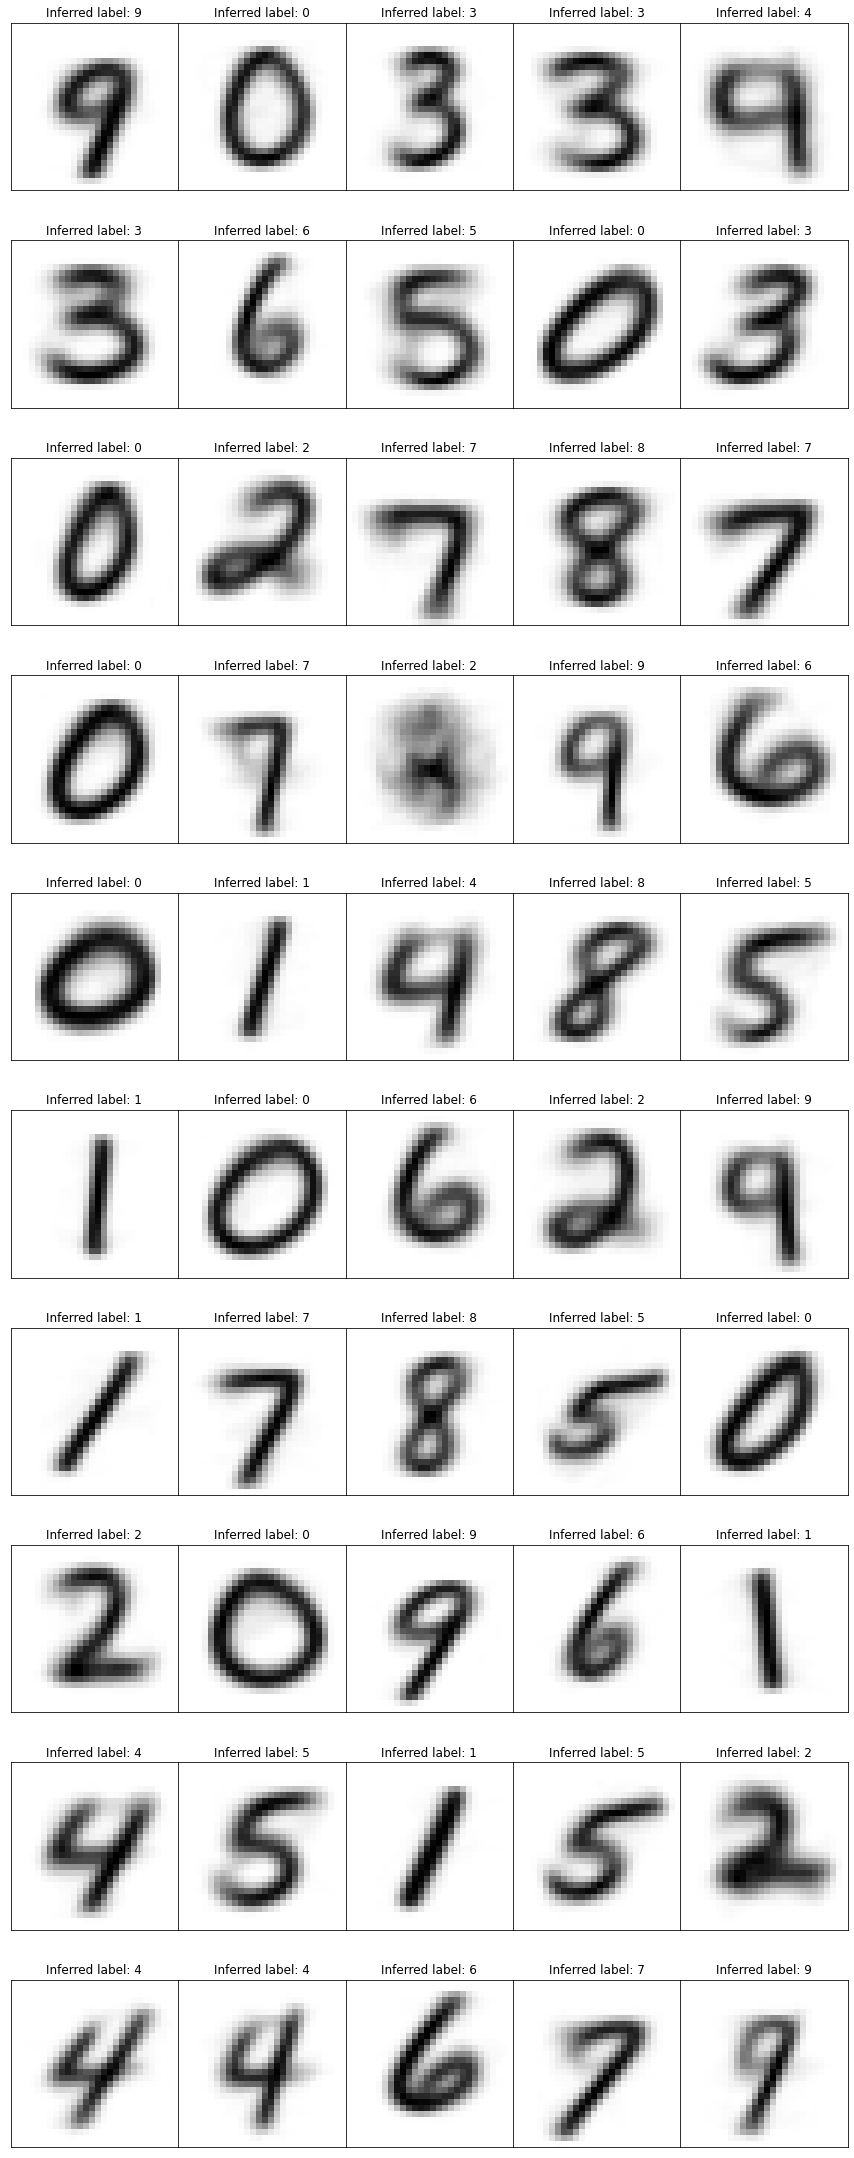

In [19]:
fig, axes = plt.subplots(10, 5, figsize=(15, 40))
plt.subplots_adjust(wspace=0, hspace=0)

for i, ax in enumerate(axes.flat):
    display_digit(trained_centers_with_labels[i], "inferred", ax)


#### Let's compute the error rate for the training and validation data. We simply assign the label of the nearest cluster center to predict the label for a given input image

In [20]:
error_rate = get_error_rate(train_data, trained_centers_with_labels)
print('Error rate on the training set with {} clusters: {:.2f}%'.format(K, error_rate*100))

Error rate on the training set with 50 clusters: 18.17%


In [21]:
error_rate = get_error_rate(val_data, trained_centers_with_labels)
print('Error rate on the validation set with {} clusters: {:.2f}%'.format(K, error_rate*100))

Error rate on the validation set with 50 clusters: 19.30%


#### Visualize the output label on a few images from the validation set

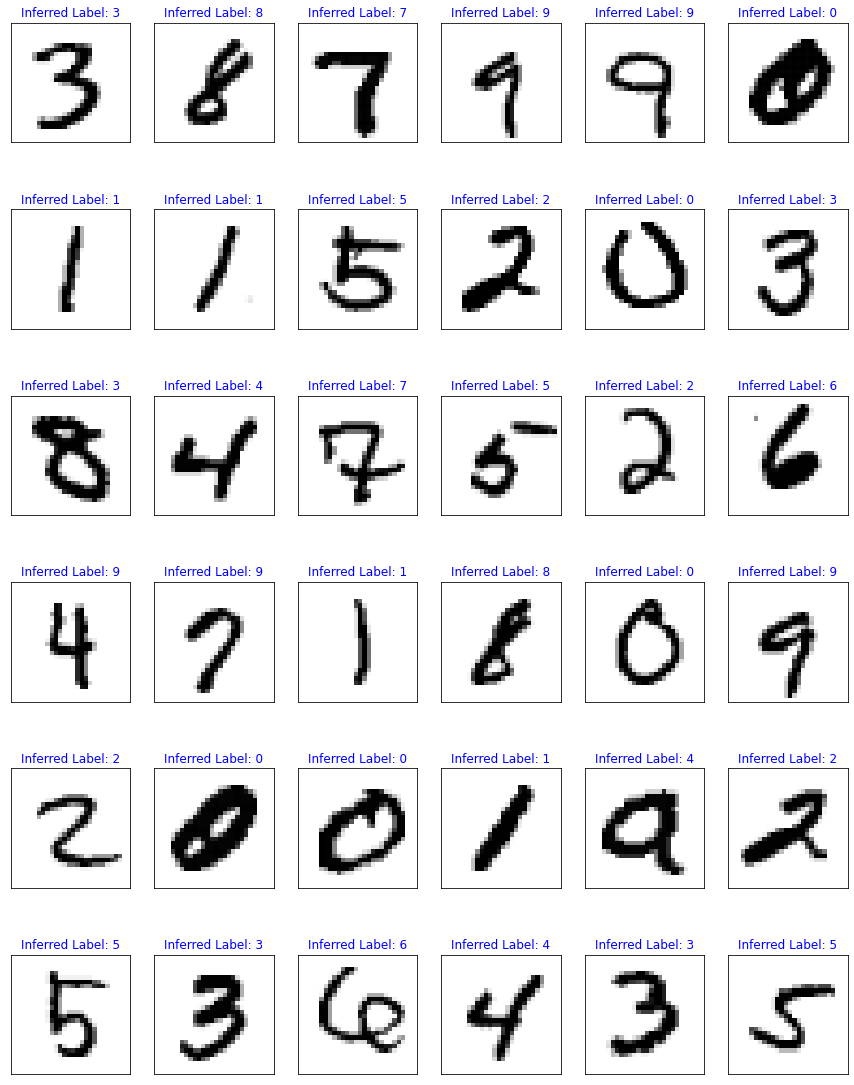

In [22]:
fig, axs = plt.subplots(6, 6, figsize = (15, 20))

for i, ax in enumerate(axs.flat):
    image  = val_data[i][1]
    pred_label  = classify_digit(image, trained_centers_with_labels)
    ax.set_title('Inferred Label: {}'.format(pred_label), color='blue')        
    ax.imshow(image.reshape(28,28), cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)